Data yang didapatkan dari kaggle akan dicoba untuk dilakukan eksplorasi. berikut adalah informasi yang dikutip dari pembuat datanya:

> A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import pandas as pd 
import numpy as np 

#import nltk for natural language toolkit
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#import string, regex, , uniqcode
import re, string, unicodedata

#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#import visualization module 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ristek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ristek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#text = happy.Description
#make a wordcloud 
def create_word_cloud(string):
    cloud = WordCloud(background_color = "white", max_words = 200, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [3]:
df = pd.read_csv('tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,NaN,JetBlueNews,NaN,0,@JetBlue's new CEO seeks the right balance to ...,NaN,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,NaN,nesi_1992,NaN,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,NaN,CPoutloud,NaN,0,@united yes. We waited in line for almost an h...,NaN,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,NaN,brenduch,NaN,0,@united the we got into the gate at IAH on tim...,NaN,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,NaN,VahidESQ,NaN,0,@SouthwestAir its cool that my bags take a bit...,NaN,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
tweet_id                        14485 non-null int64
airline_sentiment               14485 non-null object
airline_sentiment_confidence    14485 non-null float64
negativereason                  9082 non-null object
negativereason_confidence       10416 non-null float64
airline                         14485 non-null object
airline_sentiment_gold          40 non-null object
name                            14485 non-null object
negativereason_gold             32 non-null object
retweet_count                   14485 non-null int64
text                            14485 non-null object
tweet_coord                     1007 non-null object
tweet_created                   14485 non-null object
tweet_location                  9798 non-null object
user_timezone                   9710 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


## Missing value

Missing value akan dicari dan jika suatu kolom memiliki lebih dari 90% missing value, maka akan didrop

In [5]:
# count percentage of missing value
percentage_missing=round(df.isnull().sum()/len(df)*100,2).sort_values(ascending = False)
miss = [percentage_missing.index[miss] if percentage_missing[miss] > 90 else 0 for miss in range(len(percentage_missing))]
miss = list(filter((0).__ne__, miss))

In [6]:
df = df.drop(columns=miss)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0,NaN,NaN,Delta,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0,Late Flight,0.3460,United,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800,"Washington, DC",NaN
3,567592368451248130,negative,1.0,Late Flight,1.0000,United,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800,NaN,Buenos Aires
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)


## Data cleansing

Data cleansing, bertujuan untuk menghapus tanda baca, symbol dan lain lain, sehingga yang tersisa hanya kata kata saja

In [7]:
#cleansing 
def preprocessing(text):
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    def remove_between_square_brackets(text):
        return re.sub('-\[[^]]*\]', '', text)
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        return text
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)
    def remove_non_ascii(text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    text = remove_non_ascii(text)
    
    return text.lower()

In [8]:
# #apply function 
df['text'] = df['text'].progress_apply(preprocessing)

100%|██████████| 14485/14485 [00:02<00:00, 5438.92it/s]


## Stopword removal

Stopword adalah kata hubung yang tidak akan memberikan insight apapun, sehingga bisa dihapus.

In [9]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0    jetblues new ceo seeks right balance please pa...
1               jetblue really getting nerves nothappy
2    united yes waited line almost hour passengers ...
3    united got gate iah time given seats closed fl...
4    southwestair cool bags take bit longer dont gi...
Name: text, dtype: object

## Rare word removal

Digunakan untuk menghapus kata kata yang kemunculannya hanya sekali, syntax dibawah bertujuan untuk mencari kata tersebut.

In [10]:
rare_word = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
rare_word

saianel              1
httptcoeis9hcnpro    1
nevergettinghome     1
aa223                1
porn                 1
httptcoaneqxzr4bp    1
15yr                 1
httptcobcwckwtnle    1
djevolutionhd        1
okcthunder           1
dtype: int64

Setelah ditemukan, maka akan langsung dihapus

In [11]:
# removing rare words
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_word))
df['text'].head()

0    jetblues new ceo seeks right balance please pa...
1               jetblue really getting nerves nothappy
2    united yes waited line almost hour passengers ...
3    united got gate iah time given seats closed fl...
4    southwestair cool bags take bit longer dont gi...
Name: text, dtype: object

## Spelling correction

Mengoreksi kata kata yang ada pada dataset jika terdapat typo

In [12]:
df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    jetblues new co seeks right balance please pas...
1               jetblue really getting nerves nothappy
2    united yes waited line almost hour passengers ...
3    united got gate ah time given seats closed fli...
4    southwestair cool bags take bit longer dont gi...
Name: text, dtype: object

## Lemmatization

Mencari kata dasar dari kata yang telah dibenarkan ejaannya pada bagian Spelling correction. Corpus yang digunakan untuk lemmatization adalah WordNet

In [13]:
lemma = WordNetLemmatizer()

df['text'] = df['text'].apply(lambda x: " ".join([lemma.lemmatize(word) for word in x.split()]))
df['text'].head()

0    jetblues new ceo seek right balance please pas...
1                jetblue really getting nerve nothappy
2    united yes waited line almost hour passenger l...
3    united got gate iah time given seat closed fli...
4    southwestair cool bag take bit longer dont giv...
Name: text, dtype: object

## Count sentiment class

Menghitung jumlah tweet yang tergabung dalam kelas sentimen yang ada. Pada dataset, terdapat 3 kelas yaitu Negative, Neutral, dan Positive

In [14]:
#count sentiment 
sentiment = df.groupby(['airline_sentiment'])['airline_sentiment'].count()

#make dataframe that will be created a chart 
chart = pd.DataFrame(sentiment)
chart['tweet_count'] = chart['airline_sentiment']
chart.drop(['airline_sentiment'], axis = 1, inplace = True )
chart = chart.reset_index()

#make a proportion of the number of tweet of each sentiment 
chart['percent'] = chart['tweet_count']/chart['tweet_count'].sum() * 100
chart

,airline_sentiment,tweet_count,percent
0,negative,9082,62.699344
1,neutral,3069,21.187435
2,positive,2334,16.113221


## Visualization

### Barchart

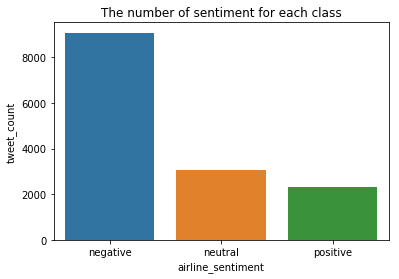

In [15]:
#make a barchart
ax = sns.barplot(x= 'airline_sentiment', y='tweet_count', data=chart)
ax = ax.set_title('The number of sentiment for each class') 

### Piechart

(-1.1202072772605616,
 1.2468369449482473,
 -1.1201615040198063,
 1.2359109677760107)

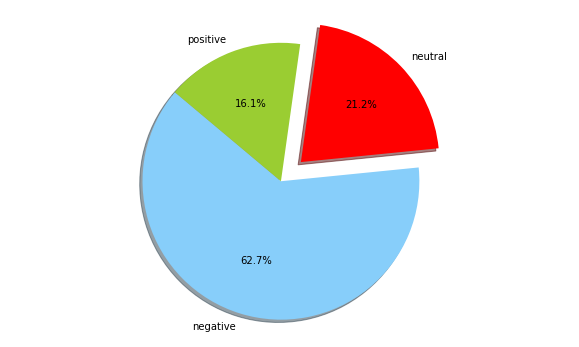

In [16]:
colors = [ 'lightskyblue','red','yellowgreen']
explode = (0, 0.2, 0)  # explode 1st slice
# Plot
figure = plt.figure(figsize= (10,6))
plt.pie(chart['tweet_count'], explode=explode, labels=chart['airline_sentiment'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

Dari tampilan barchart dan piechart dapat disimpulkan bahwa tweet negatif lebih mendominasi dengan 62.7% dari keseluruhan data tweet yang dimiliki atau sekitar 9082 tweet.

### Wordcloud

In [17]:
positive = df.loc[df['airline_sentiment'] == "positive"]
neutral = df.loc[df['airline_sentiment'] == "neutral"]
negative  = df.loc[df['airline_sentiment'] == "negative"]

In [18]:
all_tweet_positive = "".join(positive.text.values)
all_tweet_neutral = "".join(neutral.text.values)
all_tweet_negative = "".join(negative.text.values)

Kata kata yang sering diucapkan pada tweet positif

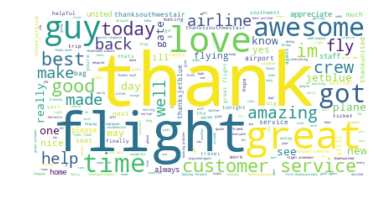

In [19]:
create_word_cloud(all_tweet_positive)

Kata kata yang sering diucapkan pada tweet netral

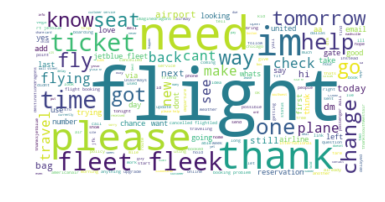

In [20]:
create_word_cloud(all_tweet_neutral)

Kata kata yang sering diucapkan pada tweet negatif

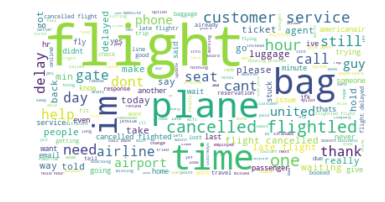

In [21]:
create_word_cloud(all_tweet_negative)

Jika dilihat dari persentase jumlah item dalam kelasnya, negative paling banyak dan memiliki masalah pada DELAY PENERBANGAN yang hingga ber jam-jam.

Pemrosesan selanjutnya akan lebih bagus jika dilakukan pencarian sumary terhadap 3 sentiment tersebut agar dapat dengan mudah disimpulkan

In [22]:
def display_topics(model, feature_names, no_top_words): #menampilkan topik
    for topic_idx, topic in enumerate(model.components_):
        print("Topic",topic_idx+1,":")
        print(" ".join([feature_names[i]
        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

negatives  = df.text[df['airline_sentiment'] == "negative"]
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(negatives)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10 #ambil 10, biar bisa disimpulin

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10 #jumlah kata tiap topik

print("Hasil summary dari tweet negative:")
display_topics(lda, tf_feature_names, no_top_words)

Hasil summary dari tweet negative:
Topic 1 :
flying taking chance door losing lga southwestair catering connection open
Topic 2 :
beyond window screw behind awesome phlairport serious expensive broke name
Topic 3 :
flight united americanair usairways hour get southwestair cancelled time jetblue
Topic 4 :
stop front drink story ny unhappy smh deliver video he
Topic 5 :
united customer usairways service americanair say email getting jetblue response
Topic 6 :
americanair cool americanairlines everything rdu weekend company yyz cheap bathroom
Topic 7 :
frustrated hang provide jet volume drop preferred blue program dept
Topic 8 :
team zero well united usairwaysfail carry gold okay carrier daughter
Topic 9 :
jetblue fleet fleek compensation apparently situation child matter hopefully baby
Topic 10 :
hold 30 min hung minute oh counting attitude husband dealing


Setelah diambil summary-nya kita mengetahui ternyata selain delay masih ada masalah pada karyawan, refund, booking response yang kurang baik dan lain lain